In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# Backtesting
After we have ascertained that our information signal has some predictive power, now we can _backtest it_ to assess whether this predicitve power can be translated into profits.

This involves designing a much more realistic trading strategy based on the signal incorporating issues such as liquidity and transaction costs. A common reason why many algorithmic trading strategies fail in practice is because **the predcitive power of the signal is limited to very small shares** where there is very little trading liquidity and high transaction costs.

## 1. Load the Data
As usual, we start by loading the returns data and the data on the signal we want to test:

In [2]:
returns = pd.read_csv('Returns.zip', parse_dates=['date']).set_index(['id', 'date'])
returns.head()

return
id    date                
10000 1986-01-31  0.000000
      1986-02-28 -0.297252
      1986-03-31  0.311436
      1986-04-30 -0.103797
      1986-05-30 -0.251873

In [3]:
db = pd.read_csv('GP.zip', parse_dates=['date']).set_index(['id', 'date'])

#We extract the factor as a Series so we can use it without worrying about the name
factor = db['gp']
factor

id     date      
10001  1986-11-28   -1.262204
       1986-12-31   -1.255969
       1987-01-30   -1.257760
       1987-02-27   -0.630571
       1987-03-31   -0.579391
                       ...   
93436  2020-08-31    0.079677
       2020-09-30    0.075038
       2020-10-30    0.144537
       2020-11-30    0.112302
       2020-12-31    0.102916
Name: gp, Length: 1882048, dtype: float64

We also load data on the **market capitalization** of each stock. This is the product of the price and the number of shares outstanding. The idea is that we will be able to invest more in larger companies without incurring huge transactions costs (Warning: market cap is an imperfect proxy for trading liquidity, but this is a topic for another day...).

In [4]:
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])
market_cap.head()

market_cap
id    date                    
10000 1986-01-31  16100.000000
      1986-02-28  11960.000000
      1986-03-31  16330.000000
      1986-04-30  15172.000000
      1986-05-30  11793.859375

___
## 2. Building the Strategy
### 2.1 The "buy" signal
As we remember from our simplified moving average strategy in week 4, the first step to build an algorithmic portfolio is to build the trading signal. Here we are looking at a **long-only** portfolio so we only need a signal that tells us when to buy a stock. 

For sake of simplicity we will limit our repertoire to a simple ranking strategy where:
1. At the beginning of the period we rank all the shares on the information signal
1. We buy the N shares at the top of the ranking

Although it seems very simplistic this is not far from the reality of the most common factor-based strategy. Both the [Citigroup Industry Rotation Model](https://drive.google.com/file/d/0B1gltCdg5OaJT3cxSWthd2hoUVk/view?usp=sharing&resourcekey=0-hDFDrZVrBtAYjkQZqiVD-A) and the [AQR Value-Momentum Strategy](https://drive.google.com/file/d/11XRh8hob05F09LbwRc9VvHLixysFriEU/view?usp=sharing) follow a similar rule where they buy the _Top-33%_ of the market. In this case they do not define the number but the percentage...

We start by defining the number `N` of shares we want to buy:

In [5]:
N=200

We use the [**`Series.rank()`**](https://pandas.pydata.org/docs/reference/api/pandas.Series.rank.html) method to rank shares in descending order (1=highest factor). Notice that since we want a different rank for every date we need to use the [**`Series.groupby()`**](https://pandas.pydata.org/docs/reference/api/pandas.Series.groupby.html) operator. 

In [6]:
rank = factor.groupby('date').rank(ascending=False, method='min')
rank.head()

id     date      
10001  1986-11-28    3529.0
       1986-12-31    3422.0
       1987-01-30    3420.0
       1987-02-27    2807.0
       1987-03-31    2649.0
Name: gp, dtype: float64

Our **buy signal** will now be simply a rank lower than `N`:

In [7]:
signal = rank < N
signal.head()

id     date      
10001  1986-11-28    False
       1986-12-31    False
       1987-01-30    False
       1987-02-27    False
       1987-03-31    False
Name: gp, dtype: bool

Notice that the logical operator returns a Boolean variable `True/False`. This works for us because internally they are treated as `True = 1` and `False = 0`. If we prefer a numerical expression we can simply use the [**`Series.astype()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html) to transform the type of the Series **to integer number**.

In [8]:
signal = signal.astype(int)
signal.head()

id     date      
10001  1986-11-28    0
       1986-12-31    0
       1987-01-30    0
       1987-02-27    0
       1987-03-31    0
Name: gp, dtype: int32

### 2.2 The Position
Now that we have the buy signal we need to **calculate the investment position**. To be more realistic we will **build a cap-weighted strategy**: if stock A and stock B are both in my "buy list" and stock A has a market capitalization double than that of stock B, then stock A will have a weight in my portfolio double than the weight of stock B.

To achieve this we need to join signal and market capitalization:

In [9]:
df = signal.rename('signal').to_frame().join(market_cap)
df.head()

signal  market_cap
id    date                          
10001 1986-11-28       0    6937.000
      1986-12-31       0    6937.000
      1987-01-30       0    6689.250
      1987-02-27       0    6193.750
      1987-03-31       0    6317.625

The code to calculate the position is not very intuitive. Let's break it down: we need to **divide the market** cap of our share **for the sum** of the market cap of all the shares in the **buy portfolio** in that **specific month**.

To get the sum of the market caps for the shares in the buy portfolio each month we need to use the [**`DataFrame.groupby()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) operator with two variables (`date` and `signal`). This will group observations by month and by whether they are in the buy portfolio or not. 

You will also notice the use of the method [**`DataFrame.transform()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html). I will explain this at the end of the section.

In [10]:
position = df['market_cap'] / df.groupby(['date', 'signal'])['market_cap'].transform('sum')
position = position * df['signal'] #this puts the weight of all the stocks not in top N to 0
position.head()

id     date      
10001  1986-11-28    0.0
       1986-12-31    0.0
       1987-01-30    0.0
       1987-02-27    0.0
       1987-03-31    0.0
dtype: float64

It is not easy to visualize the return because most observations are `0` (we only buy 200 out of 6000 shares). What we can do is to verify that in every month, **the sum of the portfolio weights** is 100%.

In [11]:
position.groupby('date').sum()

date
1980-01-31    1.0
1980-02-29    1.0
1980-03-31    1.0
1980-04-30    1.0
1980-05-30    1.0
             ... 
2020-08-31    1.0
2020-09-30    1.0
2020-10-30    1.0
2020-11-30    1.0
2020-12-31    1.0
Length: 492, dtype: float64

This is confirmed! So we have a position variable that for every time period (month here) tells us **which percentage of our portfolio will be invested in each stock**. Now that we have the portfolio composition we "only" need to simulate the investment and measure the performance.

Before we do that we can **encapsulate all this code in a function**. I will only add a line that calculates the composition of the benchmark as the cap-weighted portfolio with all the shares. This function will **return two objects**: the position and the benchmark.

In [12]:
def rank_strategy(factor_data, market_cap, N=100):
    
    #We rank the shares
    rank = factor_data.groupby('date').rank(ascending=False, method='min')
    
    #We calculate the signal
    signal = rank <= N
    signal = signal.astype(int)
    
    #We join signal and market cap
    df = signal.rename('signal').to_frame().join(market_cap)
    
    #We calculate the position
    position = df['market_cap'] / df.groupby(['date', 'signal'])['market_cap'].transform('sum')
    position = position * df['signal']
    position = position.rename('position')
    
    #We calculate the benchmark as the market weighted portfolio with all the shares
    benchmark = df['market_cap'] / df.groupby('date')['market_cap'].transform('sum')
    benchmark = benchmark.rename('benchmark')
    #We return the two series
    return position, benchmark

Let's **test** the function:

In [13]:
strat, bench = rank_strategy(factor, market_cap, 200)

strat.head()

id     date      
10001  1986-11-28    0.0
       1986-12-31    0.0
       1987-01-30    0.0
       1987-02-27    0.0
       1987-03-31    0.0
Name: position, dtype: float64

In [14]:
bench.head()

id     date      
10001  1986-11-28    0.000003
       1986-12-31    0.000003
       1987-01-30    0.000003
       1987-02-27    0.000002
       1987-03-31    0.000003
Name: benchmark, dtype: float64

___
### Coding issue: the use of .transform()

Above we had to calculate the sum of the market cap by applying the sum function within  the method [**`DataFrame.transform()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html). The reason is that we want an output with the same shape as the original data: for every share and month we want to know the sum of the weights, in that month, of all the shares with the same buy status (buy or no buy) as the share we are looking at. By using transform we get exactly this: we apply the `sum` function and **return an object with the same index** (shape) as the input.

In [15]:
df.groupby(['date', 'signal'])['market_cap'].transform('sum')

id     date      
10001  1986-11-28    2.049310e+09
       1986-12-31    1.972048e+09
       1987-01-30    2.258894e+09
       1987-02-27    2.395713e+09
       1987-03-31    2.400161e+09
                         ...     
93436  2020-08-31    2.960720e+10
       2020-09-30    2.826860e+10
       2020-10-30    2.761527e+10
       2020-11-30    3.211082e+10
       2020-12-31    3.365000e+10
Name: market_cap, Length: 1882048, dtype: float64

If we were to calculate the sum using the regular method [**`DataFrame.sum()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) we would return an object that tells us the sum of the market cap, every month, of all the shares in and out of the buy portfolio:

In [16]:
df.groupby(['date', 'signal'])['market_cap'].sum()

date        signal
1980-01-31  0         8.685047e+08
            1         6.229891e+07
1980-02-29  0         8.816603e+08
            1         5.277005e+07
1980-03-31  0         7.750039e+08
                          ...     
2020-10-30  1         3.383865e+09
2020-11-30  0         3.211082e+10
            1         2.864833e+09
2020-12-31  0         3.365000e+10
            1         2.906927e+09
Name: market_cap, Length: 984, dtype: float64

This is a bit of a complication, but all this code will be encapsulated in a function anyway. 
___

## 3. Backtesting the Position
Now that we have built our postion **we can backtest it**: we can simulate the investment strategy using past data and measure its return. The building of the backtesting function is quite complicated. This is mainly due to the **transaction costs**: to estimate the cost of trading we need to keep track of the portfolio composition month by month: the amount of trading that we need to execute in time $t$ is a function not only of the target composition of the portfolio at time $t$, but also of the actual portfolio composition at $t-1$.

Building this function is beyond the coding level required for this subject, and would force us to focus too much on the coding instead of the financial reasoning behind a specific investment strategy. To solve this problem the function has already been **created and stored in our own module** called `apmodule.py`.

This module is a simple collection of functions, some of them, such as the `rank_strategy()`, have been created in class, others have not. We will introduce the different functions in the subject as we proceed with our workshops.

For now let's **import the module** and use the backtesting function:

In [17]:
import apmodule as ap

The backtesting function requires eight inputs and produces four different output. The input parameters are:
1. The information **signal** (passed as a series)
1. The monthly **returns** (passed as the DataFrame we have loaded from the file)
1. The market **capitalization** (passed as the DataFrame we have loaded from the file)
1. The **Start** Date (this can be omitted)
1. The **End** Date (this can also be omitted)
1. The rebalancing **frequency** (the default value is rebalancing every month)
1. The round-trip **transaction costs** (the default value is zero)
1. The **number of stocks** we want to buy (works similarly to tne `N` parameter in our ranking strategy, the default value is 100)

The output produced are (in this precise order):
1. A DataFrame with the monthly **return** of the portfolio, the benchmark and the difference betwen the two (caleld _Active Return_)
1. A DataFrame with the monthly **turnover** and transaction costs of the strategy
1. A DataFrame with the **composition** of portfolio and benchmark
1. A DataFrame with a number of **performance metrics** for portfolio, benchmark and active portfolio

Before we discuss this more in detail let's take it out for a spin:

In [18]:
p_ret, p_turn, p_comp, p_perf = ap.backtesting(factor, returns, market_cap, 
                                               start='1990-01-01', end='2007-12-31', 
                                               frequency=3, t_cost=0.0015, N=200)

Let's have a look at the different output:

In [19]:
p_ret.head()

,Portfolio,Benchmark,Active
date,,,
1990-01-31,0.011095,0.014723,-0.003628
1990-02-28,0.060946,0.026269,0.034676
1990-03-30,-0.000498,-0.027565,0.027067
1990-04-30,0.113455,0.086381,0.027074
1990-05-31,0.033312,-0.004625,0.037938


In [20]:
p_turn.head()

,Turnover,T-Cost
date,,
1990-01-31,0.500000,0.000750
1990-02-28,0.000000,0.000000
1990-03-30,0.000000,0.000000
1990-04-30,0.298523,0.000448
1990-05-31,0.000000,0.000000


In [21]:
p_comp.head()

Portfolio  Benchmark
id    date                            
10001 1990-01-31        0.0   0.000004
      1990-02-28        0.0   0.000004
      1990-03-30        0.0   0.000004
      1990-04-30        0.0   0.000004
      1990-05-31        0.0   0.000004

In [22]:
p_perf

,Portfolio,Benchmark,Active
Mean Return,0.085154,0.047976,0.037178
St. Dev.,0.182997,0.145883,0.116118
RR Ratio,0.465334,0.328869,0.320176
% Positive,0.578704,0.601852,0.527778
Worst Month,-0.214710,-0.167048,-0.144830
Best Month,0.145548,0.102378,0.096661
Max DrawDown,-0.450220,-0.472201,-0.347816


Before we move to the economic interpretation of the results, let's briefly **discuss some aspects of the function**.

First of all you will notice that teh backtesting function starts from the information signal, not from the output of our ranking function. This is because the backtesting function itself **uses the ranking strategy function** (also included in the `apmodule`) so this makes our life easier. We only need one line of code.

Second, this function has been **created specifically** for this subject and needs data and input formatted according to the specification of the subject. This is a bit of let-down, but is infact a feature common to most python backtesting libraries (see for example [Backtrader](https://www.backtrader.com/) and [Quantconnect](https://www.quantconnect.com/)). I would like to reiterate that the purpose of this function is to help you test algorithmic strategy to understand the "finance" behind them. If you are interested in a more efficient general purpose backtesting function, I suggest you look at one of the providers just mentioned.

___
## 4. Assessing the performance of the strategy
Once we have run the backtesting we are left with a number of output that we can use to **see if the strategy is any good**. Here we will see what we can get out of each one of them in terms of **economic interpretation**.

### 4.1 The monthly performance
The first output of the function is a DataFrame with the monthly performance of the strategy (and the benchmark). There isn't much that we can do with this directly (apart from calculating further performance measures as we will see in a minute). For sure we can **plot the performance** to get some nice visual. We have already seen this in the code for the quantile analysis.

We start by calculating the value of the portfolio at the end of every month assuming an initial investment of 1 dollar. Since we are using logarithmic returns this is trivial. We know that if an asset has, in three periods, returns equal to $r_{1}$, $r_{2}$ and $r_{3}$, than the return from time 0 to time 3 is simply the sum
$$r_{0, 3} = \sum_{t=1}^{3}r_{t}$$

And we also know that the dollar value at the end of time 3 of a $1 investment in time 0 is

$$W_{3} = \$1\times e^{r_{0, 3}}$$

We can simply apply the Numpy exponential function [**`numpy.exp()`**](https://numpy.org/doc/stable/reference/generated/numpy.exp.html) to the cumulative returns calculated using the [**`DataFrame.cumsum()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) method. 


<AxesSubplot:title={'center':'Top-200 Rank Strategy'}, xlabel='Time', ylabel='Portfolio Value'>

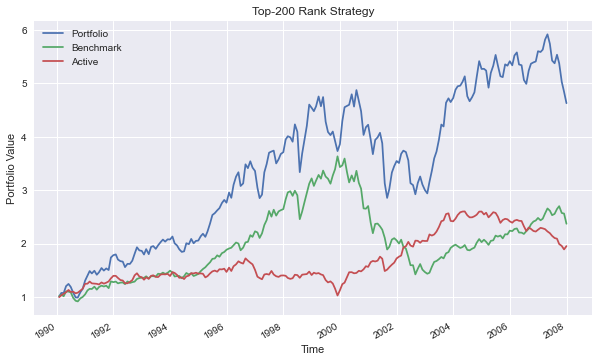

In [23]:
port_values = p_ret.cumsum().apply(np.exp)

port_values.plot(figsize=(10,6),
                 title='Top-200 Rank Strategy',
                 ylabel='Portfolio Value',
                 xlabel='Time')

___
### 4.2 Performance Metrics
The last output of the function is a very handy DataFrame with a number of performance measures, or **diagnostics**.

In [24]:
p_perf

,Portfolio,Benchmark,Active
Mean Return,0.085154,0.047976,0.037178
St. Dev.,0.182997,0.145883,0.116118
RR Ratio,0.465334,0.328869,0.320176
% Positive,0.578704,0.601852,0.527778
Worst Month,-0.214710,-0.167048,-0.144830
Best Month,0.145548,0.102378,0.096661
Max DrawDown,-0.450220,-0.472201,-0.347816


This DataFrame is built using a function `diagnostics()` contained in our `apmodule`. It is important that you are familiar with how these measures are built in case you need to build some different ones for your assignment.

We are **already familiar** with how to measure mean return, standard deviation and the Return-to-Risk ratio:

In [25]:
mean_return = p_ret.mean()*12
mean_return

Portfolio    0.085154
Benchmark    0.047976
Active       0.037178
dtype: float64

In [26]:
st_dev = p_ret.std()*np.sqrt(12)
st_dev

Portfolio    0.182997
Benchmark    0.145883
Active       0.116118
dtype: float64

In [27]:
rr_ratio = (p_ret.mean()*12) / (p_ret.std()*np.sqrt(12))
rr_ratio

Portfolio    0.465334
Benchmark    0.328869
Active       0.320176
dtype: float64

Please notice that the return-to-risk ratio of the active portfolio, also called the **Information Ratio** is one of the most important performance metrics and is commonly used as the main measure of quality of the strategy. An **IR greater than 1** is the gold standard for succesful strategy. 

After these standard measures, the table also shows some **non-parametric measures of risk**. The first one is the **percentage of months with positive return** (for the active portfolio this means months where the portfolio outperformed the benchmark). The calculation is pretty straightforward:

In [28]:
p_positive = p_ret[p_ret>0].count()/p_ret.count()
p_positive

Portfolio    0.578704
Benchmark    0.601852
Active       0.527778
dtype: float64

We then gauge the **extreme risk** of the strategy by measuring the **best and worst** monthly return:

In [29]:
worst = p_ret.min()
worst

Portfolio   -0.214710
Benchmark   -0.167048
Active      -0.144830
dtype: float64

In [30]:
best = p_ret.max()
best

Portfolio    0.145548
Benchmark    0.102378
Active       0.096661
dtype: float64

#### 4.2.1 The Max Drawdown
A performance metric that is often used in portfolio management is the so-called [Max Drawdown (MDD)](https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp), this is the maximum loss experienced by the portfolio in a given time frame. For example the 12-months MDD is the **worst drop in value** experienced by the portfolio **from the peak value** achieved within the last 12 months.  

In [31]:
#we derive the portfolio values from the monthly returns
port_values = p_ret.cumsum().apply(np.exp)

#we take the max portfolio value over the last 12 months
rolling_peak = port_values.rolling(12).max()

#we take the percentage difference between the current value and the rolling peak
drawdown = np.log(port_values/rolling_peak)

#we take the worst drawdown experienced (...called max because it's a negative number...)
max_drawdown = drawdown.min().rename('Max Drawdown')
max_drawdown

Portfolio   -0.450220
Benchmark   -0.472201
Active      -0.347816
Name: Max Drawdown, dtype: float64

Some people like to **plot the Drawdown** to provide a visual indication of when the portfolio experienced the worst consecutive loss:

<AxesSubplot:title={'center':'12-M Drawdown'}, xlabel='Time', ylabel='Drawdown %'>

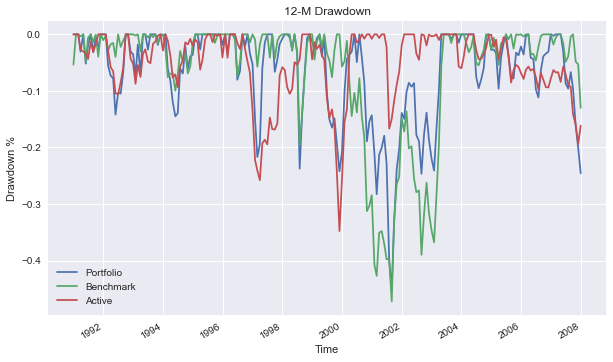

In [32]:
drawdown.plot(figsize=(10,6),
              title='12-M Drawdown',
              ylabel='Drawdown %',
              xlabel='Time')

To understand the meaning of the drawdown we can plot the value of the portfolio and observe that the MDD captures the sharp fall in the portfolio value after the **bursting of the dot.com bubble** of March 2000.

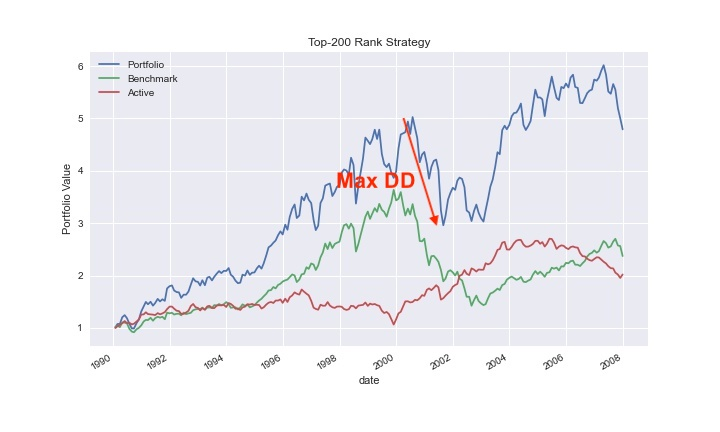

All these performance measures can then be included in a simple function. Please notice that this function is available in `apmodule` and is called automatically by the backtesting function.

In [33]:
def diagnostics(port_ret):
    mean_return = port_ret.mean()*12
    volatility = port_ret.std()*np.sqrt(12)
    rr_ratio = (port_ret.mean()*12) / (port_ret.std()*np.sqrt(12))
    p_positive = port_ret[port_ret>0].count()/port_ret.count()
    worst = port_ret.min()
    best = port_ret.max()
    
    #we derive the portfolio values from the monthly returns
    port_val = port_ret.cumsum().apply(np.exp)
    rolling_peak = port_val.rolling(12).max()
    drawdown = np.log(port_val/rolling_peak)
    max_drawdown = drawdown.min().rename('Max Drawdown')

    performance = pd.DataFrame({'Mean Return': mean_return,
                                'St. Dev.': volatility,
                                'RR Ratio': rr_ratio,
                                '% Positive': p_positive,
                                'Worst Month': worst,
                                'Best Month': best,
                                'Max DrawDown': max_drawdown})
    
    return performance.transpose()

___
### 4.3 Turnover Analysis
We can also analyze the **dynamics of the turnover** and transaction costs. These are contained in the second output of the backtesting function. Let's, for example, calculate the total turnover for each calendar year:

<AxesSubplot:title={'center':'Turnover'}, xlabel='Year', ylabel='(%)'>

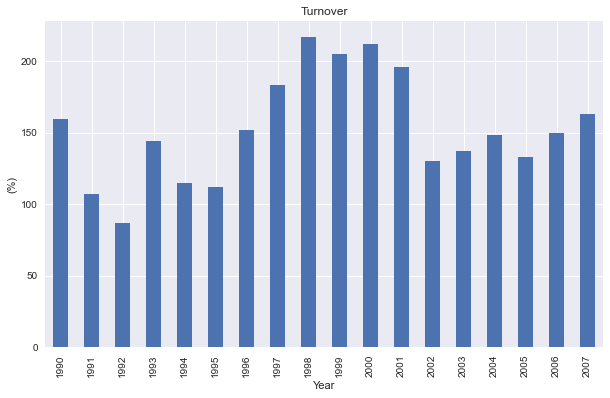

In [34]:
#we generate a column with the years extracted by the index
p_turn['year'] = p_turn.index.year

#we sum the monthly turnover by year
turn = p_turn.groupby('year')['Turnover'].sum()*100

#we plot
turn.plot(figsize=(10,6),
          kind='bar',
          title='Turnover',
          ylabel='(%)',
          xlabel='Year')

We see that **every year we buy and sell** between 80% and 200% of the portfolio value. This generates a certain amount of annual transaction costs:

<AxesSubplot:title={'center':'Transaction Costs'}, xlabel='Year', ylabel='(%)'>

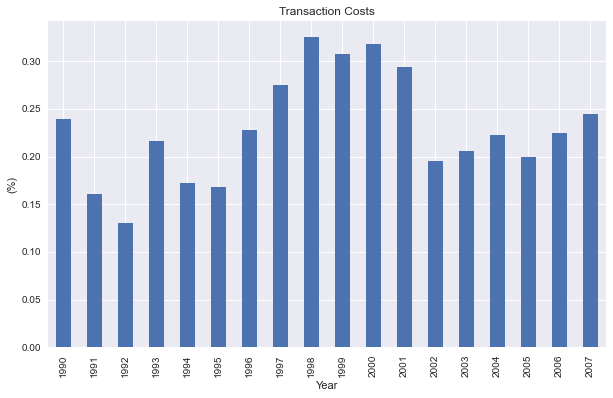

In [35]:
#we sum the monthly transaction cost by year
t_cost = p_turn.groupby('year')['T-Cost'].sum()*100

#we plot
t_cost.plot(figsize=(10,6),
            kind='bar',
            title='Transaction Costs',
            ylabel='(%)',
            xlabel='Year')

At the top of the tech bubble this strategy should have generated transaction costs of 0.3% per year. This is almost one tenth of the average active return of the strategy.

___
### 5.3 Industry Exposure
The third output of the backtesting function is the composition of the portfolio (and of the benchmark). While we mainly care about the performance of a strategy, it is useful to know **in which type of stocks** we are actually investing to keep an eye on our **exposure to different risk factors**. 

One typical example is our **industry exposure**: how much of the portfolio is invested in tech stocks? How much in the hospitality industry? This will, for example, drive the peorformance of our stragegy during the pandemic.

In our strategy, portfolio composition is determined purely by a single information signal...but what if all the companies in a given industry rank very well (or very poorly) based on that signal?

To start, we can load the file `names.zip` that **contains name and industry** affiliation of all the companies in our sample.

In [36]:
names = pd.read_csv('names.zip').set_index('id')
names.head()

,name,industry
id,,
10001,GAS NATURAL INC,Utilities
10002,BANCTRUST FINANCIAL GROUP INC,Finance
10003,GREAT COUNTRY BK ASONIA CT,Finance
10005,WESTERN ENERGY RESOURCES INC,"Oil, Gas, and Coal"
10006,A C F INDUSTRIES INC,Manufacturing


Let's now **merge this with our strategy** DataFrame (the one with the target weights).

In [37]:
p_comp = p_comp.join(names, how='left')
p_comp.head()

Portfolio  Benchmark             name   industry
id    date                                                        
10001 1990-01-31        0.0   0.000004  GAS NATURAL INC  Utilities
      1990-02-28        0.0   0.000004  GAS NATURAL INC  Utilities
      1990-03-30        0.0   0.000004  GAS NATURAL INC  Utilities
      1990-04-30        0.0   0.000004  GAS NATURAL INC  Utilities
      1990-05-31        0.0   0.000004  GAS NATURAL INC  Utilities

We can now estimate industry exposure by **summing the weights of all the stocks in each industry**. We want to calculate this exposure every month, so we use a double **`.groupby()`**: we need to group by date and then by industry. 

In [38]:
port_exposure = p_comp.groupby(['date', 'industry'])['Portfolio'].sum()
port_exposure.head()

date        industry             
1990-01-31  Business Equipment       0.277002
            Chemicals                0.053797
            Consumer Durables        0.000269
            Consumer non Durables    0.185728
            Finance                  0.003120
Name: Portfolio, dtype: float64

Since we used a double groupby operator, the result has a **multiindex**: every observation is indexed by **date AND industry**. It is easier for us to have **each industry** in a different column:

In [39]:
port_exposure = port_exposure.unstack(level=1)
port_exposure.head()

industry,Business Equipment,Chemicals,Consumer Durables,Consumer non Durables,Finance,Healthcare,Manufacturing,"Oil, Gas, and Coal",Other,Retail,Telecommunications,Utilities
date,,,,,,,,,,,,
1990-01-31,0.277002,0.053797,0.000269,0.185728,0.003120,0.123041,0.017393,0.004649,0.034798,0.299363,0.000838,0.0
1990-02-28,0.247638,0.081346,0.000241,0.174087,0.002708,0.111888,0.018783,0.000545,0.019869,0.342481,0.000414,0.0
1990-03-30,0.244531,0.046292,0.010187,0.159718,0.003795,0.106288,0.020285,0.004099,0.015642,0.388748,0.000416,0.0
1990-04-30,0.254479,0.062769,0.010333,0.081149,0.000957,0.113843,0.044884,0.004160,0.015386,0.411592,0.000449,0.0
1990-05-31,0.297150,0.060922,0.000616,0.126719,0.000923,0.124836,0.045061,0.003254,0.014673,0.325380,0.000466,0.0


<AxesSubplot:title={'center':'Portfolio Industry Exposure'}, xlabel='Year', ylabel='Portfolio %'>

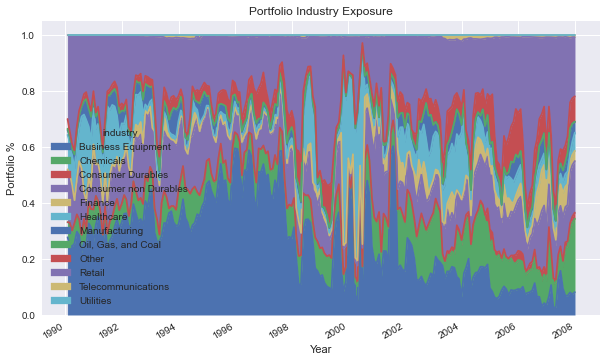

In [40]:
port_exposure.plot(figsize=(10,6),
                   kind='area',
                   ylabel='Portfolio %',
                   xlabel='Year',
                   title='Portfolio Industry Exposure')

**What a mess!** This picture is a disaster... Let's see:
* The legend overlaps and cover valuable information
* The colors are repeated so it is difficult to understand what is what
* The grey border looks weird

Let's try to fix them:

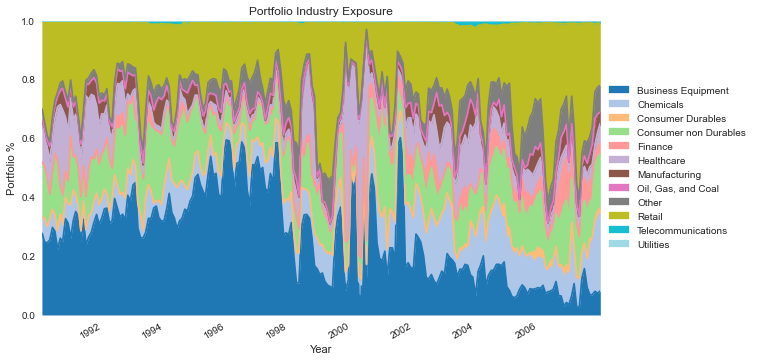

In [41]:
port_exposure.plot(figsize=(10,6),
                   kind='area',
                   ylabel='Portfolio %',
                   xlabel='Year',
                   title='Portfolio Industry Exposure',
                   colormap='tab20',
                   ylim=[0,1],
                   xlim=[port_exposure.index.min(), port_exposure.index.max()])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Better...:
* The `xlim=[]` and `ylim=[]` parameters specify the limits for the `x` and `y` axis and so we get rid of the weird grey border. Notice that for the `x` axis we could have simply written `xlim=[1980, 2020]` but that could break with a different sample. With the current version we look for min/max year in the sample.
* The  `colormap=` parameter changes the colormap from the default one to one with 20 colors so they are not repeated (a list of colormaps can be found [here](https://matplotlib.org/stable/gallery/color/colormap_reference.html)).

When it comes to the **legend**, the problem is that the integration of `matplotlib` with `pandas` **does not allow to move it** or change it in any way. So here we need to use the **standard** `matplotlib` **syntax** to move the legend. The syntax of the line is a bit complex, so if you want you can read more [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html). 

While the picture now is ok, the graph still looks weird, but that is a problem with our data: we are building our monthly target weights by looking at accounting data (the Gross Profitability Ratio). Since US companies release quarterly accounting information, we get a lot of seasonality: retail companies have a boost in revenues and profit in the 4th quarter (Christmas shopping)...

To remedy this we can look at the **average yearly exposure**:

In [42]:
#we extract the year from the index
port_exposure['year'] = port_exposure.index.year

#we calculate the mean exposure by year (for simplicity we replace the old DataFrame)
port_exposure = port_exposure.groupby('year').mean()
port_exposure.head()

industry,Business Equipment,Chemicals,Consumer Durables,Consumer non Durables,Finance,Healthcare,Manufacturing,"Oil, Gas, and Coal",Other,Retail,Telecommunications,Utilities
year,,,,,,,,,,,,
1990,0.269929,0.066540,0.003506,0.146596,0.001614,0.161179,0.043159,0.003171,0.020042,0.283871,0.000393,0.0
1991,0.305219,0.063224,0.000333,0.130466,0.008658,0.171330,0.049964,0.001972,0.020640,0.247761,0.000433,0.0
1992,0.362136,0.073446,0.000737,0.186600,0.014835,0.085333,0.045886,0.003841,0.023328,0.202262,0.001595,0.0
1993,0.325577,0.068161,0.002597,0.213168,0.013440,0.023242,0.052653,0.004549,0.039891,0.248557,0.008164,0.0
1994,0.363671,0.101452,0.003469,0.197914,0.010799,0.024302,0.037407,0.003493,0.029559,0.219419,0.008513,0.0


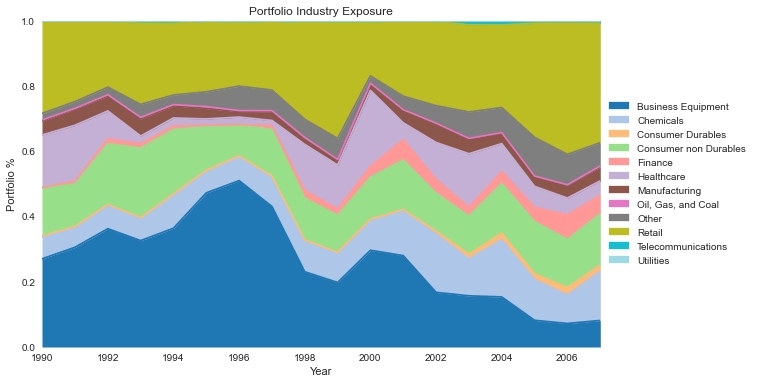

In [43]:
#and then we can plot
port_exposure.plot(figsize=(10,6),
                   kind='area',
                   ylabel='Portfolio %',
                   xlabel='Year',
                   title='Portfolio Industry Exposure',
                   colormap='tab20',
                   ylim=[0,1],
                   xlim=[port_exposure.index.min(), port_exposure.index.max()])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Now that the picture is finally fixed we can observe the industry exposure of our portfolio. We see, for example, that after 1997 our exposure to business equipment is greatly reduced. It is not clear **if this is an active bet** of our strategy, or if it simply reflects the dynamic of the general market. To answer this question we need to look at the **industry exposure of our benchmark**.

Since, in this simple simulation our **benchmark is market-cap weighted**, we can simply sum the weights here too.

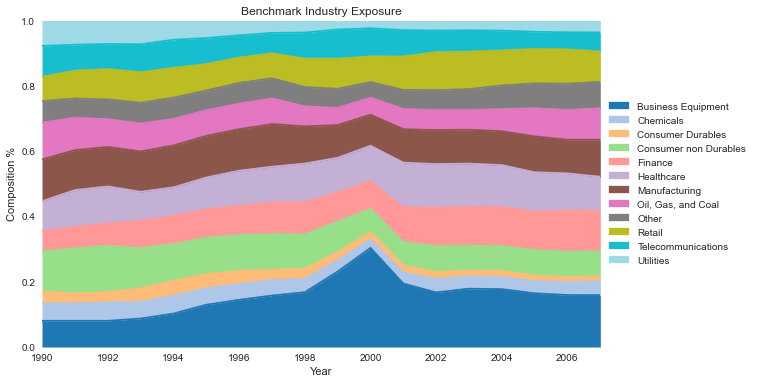

In [44]:
#we sum teh weights of the stocks for each industry and month
bench_exposure = p_comp.groupby(['date', 'industry'])['Benchmark'].sum()

#we put the data of each industry in a different column
bench_exposure = bench_exposure.unstack(level=1)

#we xtract the year from the index
bench_exposure['year'] = bench_exposure.index.year

#we take the mean average exposure within each year and plot
bench_exposure = bench_exposure.groupby('year').mean()

bench_exposure.plot(figsize=(10,6),
                    kind='area',
                    ylabel='Composition %',
                    xlabel='Year',
                    title='Benchmark Industry Exposure',
                    colormap='tab20',
                    ylim=[0,1],
                    xlim=[bench_exposure.index.min(), bench_exposure.index.max()])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

And from comparing the industry exposure of our portfolio to that of the benchmark we see that our profitability strategy has an **implied long bet** on Business Equipment and Retail, and an **implied short bet** on Finance and Manufacturing.

In fact we can also define the **difference** between the portfolio and benchmark weights each year to see the dynamics of these relative bets:

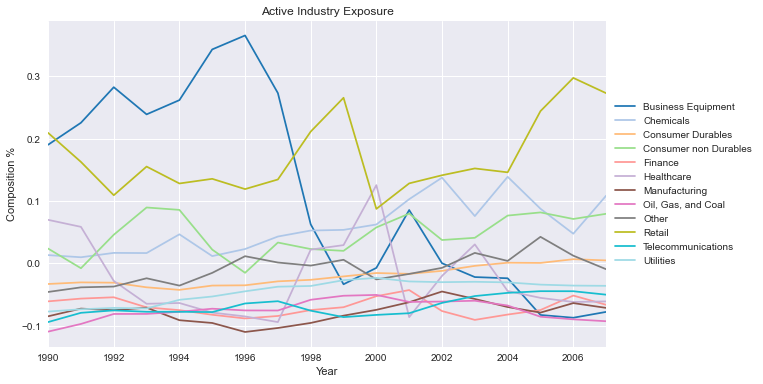

In [45]:
#we define the difference between the portfolio and benchmark exposure (called active)
active_exposure = port_exposure-bench_exposure

active_exposure.plot(figsize=(10,6),
                    kind='line',
                    ylabel='Composition %',
                    xlabel='Year',
                    title='Active Industry Exposure',
                    colormap='tab20',
                    xlim=[active_exposure.index.min(), active_exposure.index.max()])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

___
### Exercise 09.01
While many investors and portfolio managers love momentum strategies, other have a feeling that these strategies have overstayed their welcome: they used to perform well in the past but in the last years they have been underwhelming. Load the data on 12-months momentum from `MOM12.zip` and backtest the strategy three times on three different periods:
* 1990 - 1999
* 2000 - 2009
* 2010 - 2019

Is it true that the profitability of this strategy has decreased? 

**STEP 1:** Load the data on 12-months momentum from `MOM12.zip`

In [46]:
dm = pd.read_csv('MOM12.zip', parse_dates=['date']).set_index(['id', 'date'])
dm.head()

mom12
id    date                
10001 1987-02-27  0.051463
      1987-03-31 -0.247225
      1987-04-30 -0.130483
      1987-05-29 -0.154814
      1987-06-30 -0.229010

**STEP 2:** Run the backtesting function 3 times changing `start` and `end` to match the three windows described in the question. Choose different names for the output DataFrames to make them easily recognizable. Use the default values for rebalancing frequency, transaction costs and number of shares. 

In [47]:
m_ret90, m_turn90, m_comp90, m_perf90 = ap.backtesting(dm['mom12'], returns, market_cap, start='1990-01-01', end='1999-12-31')

m_ret00, m_turn00, m_comp00, m_perf00 = ap.backtesting(dm['mom12'], returns, market_cap, start='2000-01-01', end='2009-12-31')

m_ret10, m_turn10, m_comp10, m_perf10 = ap.backtesting(dm['mom12'], returns, market_cap, start='2010-01-01', end='2019-12-31')

**STEP 3:** Show if the performance of the strategy has declined. You can do this by simply showing the performance tables of the three strategies. 

In [48]:
m_perf90

,Portfolio,Benchmark,Active
Mean Return,0.264640,0.125357,0.139283
St. Dev.,0.352148,0.135314,0.276836
RR Ratio,0.751504,0.926420,0.503126
% Positive,0.641667,0.666667,0.575000
Worst Month,-0.243976,-0.176449,-0.197025
Best Month,0.349892,0.102627,0.296697
Max DrawDown,-0.460462,-0.201871,-0.553962


In [49]:
m_perf00

,Portfolio,Benchmark,Active
Mean Return,-0.227637,-0.058538,-0.169098
St. Dev.,0.342858,0.172077,0.256450
RR Ratio,-0.663938,-0.340186,-0.659382
% Positive,0.458333,0.541667,0.433333
Worst Month,-0.434884,-0.201615,-0.318863
Best Month,0.281993,0.087486,0.286778
Max DrawDown,-1.289897,-0.695645,-0.836907


In [50]:
m_perf10

,Portfolio,Benchmark,Active
Mean Return,0.064439,0.105635,-0.041196
St. Dev.,0.236507,0.128603,0.163411
RR Ratio,0.272463,0.821401,-0.252098
% Positive,0.550000,0.700000,0.541667
Worst Month,-0.221176,-0.100567,-0.157821
Best Month,0.159230,0.103407,0.092571
Max DrawDown,-0.458810,-0.205725,-0.394976


**STEP 4 (Coding Challenge):** Here is something more original. Many times when you want to push a message across, for example convincing your boss to drop this strategy, you want to be as "punchy" as possible. Let's see if you can plot a simple bar graph with Information Ratio of the three strategies. Of course you could simply copy the three numbers and do the graph in Excel. This would take 90 seconds, **and would be the smart thing to to do**...but let's see if you can do it in Python. 

**HINT 1:** To access a single number in the DataFrame you need to use the [**`DataFrame.loc()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) method passing the name of the row and the name of the column. For example to access the percentage of positive returns for the benchmark in the main example in the test you would use:
```python
p_perf.loc['% Positive', 'Benchmark']
```

**HINT 2:** To transform some numbers into a DataFrame you need to use the [**`pandas.DataFrame()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) passing the numbers as a list.

In [51]:
ir = [m_perf90.loc['RR Ratio','Active'], m_perf00.loc['RR Ratio','Active'], m_perf10.loc['RR Ratio','Active']]
ir

[0.5031258283162833, -0.6593816217974132, -0.252098140327728]

In [52]:
info_ratio = pd.DataFrame(ir, index=['1990-1999', '2000-2009', '2010-2019'], columns=['Information Ratio'])
info_ratio

,Information Ratio
1990-1999,0.503126
2000-2009,-0.659382
2010-2019,-0.252098


<AxesSubplot:title={'center':'Information Ratio Momentum Strategy'}, xlabel='Backtesting Period', ylabel='Annualized Information Ratio'>

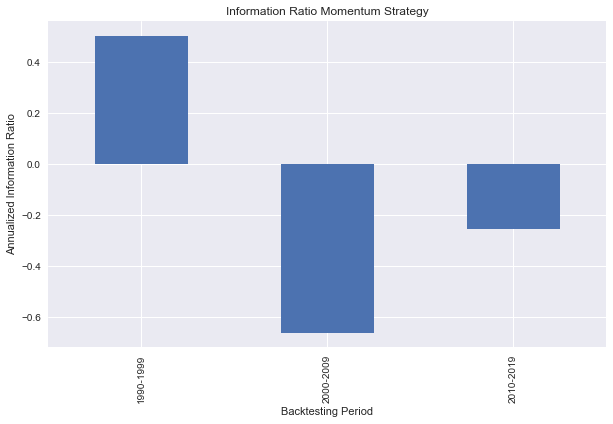

In [53]:
info_ratio.plot(figsize=(10,6),
                kind='bar',
                title='Information Ratio Momentum Strategy',
                xlabel='Backtesting Period',
                ylabel='Annualized Information Ratio',
                legend=False)

___
### Exercise 09.02
In the profitability strategy above (in the main notebook) we have assumed that investing in the top 200 shares was a good idea. This is a **parameter that should be analyzed and optimized**.

Use a `for-loop` to run the backtesting of the profitability strategy with four different values for the parameter `N` (keeping all the other parameters as in the main text). You should try investing in the top: 50, 200, 500, 1000 shares. After each iteration of the for loop save the information ratio of the strategy. At the end observe what would have been the optimal parameter.

**HINT:** To access the information ratio after each iteration check the hint 1 to the previous exercise.

In [55]:
numbers = [50, 200, 500, 1000]

info_ratio=[]

for number in numbers:
    
    p_ret, p_turn, p_comp, p_perf = ap.backtesting(factor, returns, market_cap, 
                                                   start='1990-01-01', end='2007-12-31', 
                                                   frequency=3, t_cost=0.0015, N=number)
    
    info_ratio.append(p_perf.loc['RR Ratio', 'Active'])
    
print(info_ratio)

[-0.22112828406250412, 0.3201763007669044, 0.5492131587438742, 0.6345349643147015]


At the end you should observe that the performance of the strategy **improves with a larger number of shares** in the portfolio.